<a href="https://colab.research.google.com/github/Hyeseong0317/Pytorch_Capstone_Design/blob/main/ResNet18_computervision_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [10]:
# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [11]:
net = ResNet18()

In [ ]:
inputs = torch.Tensor(30, 1, 224, 224)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([30, 1, 224, 224])


In [ ]:
net(inputs)

tensor([[ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364, -0.0312],
        [ 0.0324,  0.0028, -0.0364

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                         
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                        
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [14]:
data_dir = '/content/drive/Shareddrives/8:1:1/OCT2017(8:1:1)'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val', 'test']}


In [15]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=14,
                                             shuffle=True, drop_last=True, num_workers=2)
                    for x in ['train', 'val', 'test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


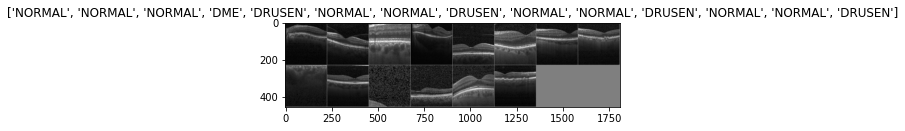

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
for id, data in enumerate(dataloaders['train']):
  print(id)
  img = data[0]
  label = data[1]
  print(img.shape)
  print(label.shape)
  break

0
torch.Size([14, 1, 224, 224])
torch.Size([14])


In [16]:
inputs = torch.Tensor(14, 1, 224, 224)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([14, 1, 224, 224])


In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [18]:
model_ft = ResNet18()

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6210 Acc: 0.7702
val Loss: 0.5258 Acc: 0.8000

Epoch 1/19
----------
train Loss: 0.4207 Acc: 0.8454
val Loss: 0.4030 Acc: 0.8479

Epoch 2/19
----------
train Loss: 0.3891 Acc: 0.8580
val Loss: 0.3712 Acc: 0.8649

Epoch 3/19
----------
train Loss: 0.3532 Acc: 0.8718
val Loss: 0.3935 Acc: 0.8540

Epoch 4/19
----------
train Loss: 0.3373 Acc: 0.8777
val Loss: 0.3468 Acc: 0.8749

Epoch 5/19
----------
train Loss: 0.3222 Acc: 0.8812
val Loss: 0.3604 Acc: 0.8673

Epoch 6/19
----------
train Loss: 0.3121 Acc: 0.8870
val Loss: 0.3258 Acc: 0.8849

Epoch 7/19
----------
train Loss: 0.2769 Acc: 0.8988
val Loss: 0.2858 Acc: 0.8943

Epoch 8/19
----------
train Loss: 0.2631 Acc: 0.9045
val Loss: 0.2811 Acc: 0.8973

Epoch 9/19
----------
train Loss: 0.2608 Acc: 0.9048
val Loss: 0.2880 Acc: 0.8907

Epoch 10/19
----------
train Loss: 0.2578 Acc: 0.9070
val Loss: 0.2920 Acc: 0.8958

Epoch 11/19
----------
train Loss: 0.2607 Acc: 0.9057
val Loss: 0.2830 Acc: 0.8953

Ep

In [27]:
# Present working directory
!pwd

/content/drive/Shareddrives/ResNet18_Model_parameters


In [28]:
os.chdir('/content/drive/Shareddrives/ResNet18_Model_parameters')

In [29]:
# Present working directory
!pwd

/content/drive/Shareddrives/ResNet18_Model_parameters


In [30]:
PATH = 'ResNet18_retina.pth'

In [31]:
torch.save(net.state_dict(), PATH)
print('Model Saved!')

Model Saved!


In [40]:
net = ResNet18()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [37]:
plt.plot(epochs, losses)
plt.ylabel('Val LOSS')
plt.xlabel('Epoch')

NameError: ignored

In [41]:
net.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [42]:
def test_model(model, num_epochs=1):
    
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['test']:
            
            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
           

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

           
        print()

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))


In [43]:
test_model = test_model(net)

Epoch 0/0
----------
test Loss: 1.5761 Acc: 0.0818

Testing complete in 44m 46s
Best Test Acc: 0.000000
